## CSCI E-108 Computer Vision Final Project Report
### Semantic Segmentation
Alex Coward\
Spring Term 2024

### 1. Project Overview

For my final project, I experimented with semantic segmentation for street driving scenes using the CamVid dataset. There are many models used for semantic segmentation, and I used the U-Net architecture with a VGG16 pre-trained encoder and a decoder built using a Keras functional model which I trained using Google Colab Pro. I tried various model hyperparameters as I will discuss below, and my best-performing model had a Mean IoU (a primary metric used in evaluating semantic segmentation) of 0.866 on the training set and of 0.539 on the test set.

### 2. Semantic Segmentation Overview

Semantic segmentation is a dense classification task where the goal is to classify every pixel in the input image. The input to the model is an image, which can be grayscale or RGB. The label has dimensions equal to the height and width of the input image, with a label assigned to every pixel. For the purposes of this project the output of the model has the same first two dimensions as the label, with n additional dimensions where each dimension contains the probability that a given pixel belongs to one of n classes. For example, a dataset of (360, 480, 3) images and 12 classes would have a label of dimensions (360, 480) and an output of (360, 480, 12).

### 3. Imports

In [ ]:
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import os
import json
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator

from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D,Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, load_model
from keras.applications import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input

!pip install focal_loss
import focal_loss

from google.colab import drive
drive.mount('/content/drive')

### 4. Global Variables




The variables in this cell are used to control model training

In [ ]:
# SMALL IMAGE SIZE, NUMBER OF CLASSES DATASET
input_size = (360,480,3)
num_classes = 12

# LARGE IMAGE SIZE, NUMBER OF CLASSES DATASET
#input_size = (720,960,3)
#num_classes = 32

# VGG16 WEIGHTS FROZEN OR NOT
encoder_status = "frozen"
#encoder_status = "not_frozen"

# SELECT LOSS FUNCTION
loss_function = "categorical_loss"
#loss_function = "focal_loss"

# IF USING FOCAL LOSS, NEED TO SET
# GAMMA HYPERPARAMETER
gamma = 2

# SELECT BATCH SIZE. ON GOOLGE COLAB PRO
# T4 W/ HIGH RAM, 16 WORKS FOR SMALL IMAGE DATASET
# AND 4 WORKS FOR LARGE IMAGE DATASET
batch_size = 16
#batch_size = 4


# SELECT EPOCHS
epochs = 120

# IF USING CATEGORICAL LOSS, SELECT
# WHETHER OR NOT TO USE CLASS WEIGHTS TO ASSIST
# WITH CLASS INBALANCE
class_balancing = True
#class_balancing = False


### 5. CamVid Dataset

The dataset used for training the U-Net Model is the CamVid street driving dataset. I found two versions of the dataset and experimented with both. The original dataset can be found here: http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

The original dataset features 704 RGB images of size (720, 960, 3), (370 train, 101 validation, 233 test), 704 RGB images of size (720, 960, 3) where the RGB value of every pixel represents the pixel's labelled class, and a CSV file that  matches every RGB value in the label images to one of 32 possible classes. The images are still images taken from a video of over 10 minutes of street scenes recorded by a camera mounted in a car and feature diverse objects.

A second version of the dataset can be found here: https://github.com/alexgkendall/SegNet-Tutorial/tree/master/CamVid and is a re-worked version of the original dataset that was used as part of the work presented in the paper "SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation" (https://arxiv.org/pdf/1511.00561). The GitHub page belongs to one of the co-authors of the paper, Alex Kendall. The second dataset features 704 RGB images of size (360, 480, 3) (368 train, 102 validation, 234 test), 704 grayscale images of size (360, 480) where the grayscale value represents the pixel's class across 12 classes.

Given the computational resources required to train a model with the larger (720, 960, 3) images, after some initial tests I focused my efforts on the (360, 480, 3) dataset.

Dataset citations:
- Segmentation and Recognition Using Structure from Motion Point Clouds, ECCV 2008 (Brostow, Shotton, Fauqueur, Cipolla (http://www.inf.ethz.ch/personal/gbrostow/ext/MotionSegRecECCV08.pdf)
- Semantic Object Classes in Video: A High-Definition Ground Truth Database Pattern Recognition Letters (to appear) Brostow, Fauqueur, Cipolla (http://www0.cs.ucl.ac.uk/staff/G.Brostow/)

  
  
  




### 6. EDA and Data Pre-Processing

#### Dataset Paths

Depending on what is selected in the Global Variables cell, either the (360, 480, 3) images or the (720, 960, 3) images will be used for model training.

In [ ]:
if input_size == (360,480,3):

  train_image_path = '/content/drive/MyDrive/CamVid/train'
  train_map_path = '/content/drive/MyDrive/CamVid/trainannot'

  val_image_path = '/content/drive/MyDrive/CamVid/val'
  val_map_path = '/content/drive/MyDrive/CamVid/valannot'

  test_image_path = '/content/drive/MyDrive/CamVid/test'
  test_map_path = '/content/drive/MyDrive/CamVid/testannot'

else:

  train_image_path = '/content/drive/MyDrive/cv_final_project/CamVid/train'
  train_mask_path = '/content/drive/MyDrive/cv_final_project/CamVid/train_labels'
  train_map_path = '/content/drive/MyDrive/cv_final_project/maps/train_maps_2'

  val_image_path = '/content/drive/MyDrive/cv_final_project/CamVid/val'
  val_mask_path = '/content/drive/MyDrive/cv_final_project/CamVid/val_labels'
  val_map_path = '/content/drive/MyDrive/cv_final_project/maps/val_maps_2'

  test_image_path = '/content/drive/MyDrive/cv_final_project/CamVid/test'
  test_mask_path = '/content/drive/MyDrive/cv_final_project/CamVid/test_labels'
  test_map_path = '/content/drive/MyDrive/cv_final_project/maps/test_maps_2'


#### Class Dictionaries

The RBG to class map is provided with the dataset for the (720, 960, 3) version of the dataset, but for the (360, 480, 3) version this is not available in the original paper and isn't clearly listed on the co-author's GitHub page. Information on that page and on this page (https://github.com/lih627/CamVid/blob/main/camvid_data.py), along with inspection of the data and model predictions, was used to verify the correct mapping.

In [ ]:
if input_size == (360,480,3):

	name_to_rgb = {
	'sky':(128,128,128),
	'building':(128,0,0),
	'pole':(192,192,128),
	'road':(128,64,128),
	'sidewalk':(60,40,222),
	'tree':(128,128,0),
	'sign_symbol':(192,128,128),
	'fence':(64,64,128),
	'car':(64,0,128),
	'pedestrian':(64,64,0),
	'bicyclist':(0,128,192),
	'unlabelled':(0,0,0)}

	idx_to_rgb = {
	0:(128,128,128),
	1:(128,0,0),
	2:(192,192,128),
	3:(128,64,128),
	4:(60,40,222),
	5:(128,128,0),
	6:(192,128,128),
	7:(64,64,128),
	8:(64,0,128),
	9:(64,64,0),
	10:(0,128,192),
	11:(0,0,0)}

	idx_to_name = {
	0:'sky',
	1:'building',
	2:'pole',
	3:'road',
	4:'sidewalk',
	5:'tree',
	6:'sign_symbol',
	7:'fence',
	8:'car',
	9:'pedestrian',
	10:'bicyclist',
	11:'unlabelled'}

else:

  class_table = pd.read_csv('/content/drive/MyDrive/cv_final_project/CamVid/class_dict.csv')

  class_table['r_g_b'] = list(zip(class_table['r'], class_table['g'], class_table['b']))
  class_table['idx'] = np.arange(0,32)

  rgb_to_name = {row['r_g_b']:row['name'] for index, row in class_table.iterrows()}
  name_to_rgb = {value:key for key, value in rgb_to_name.items()}

  rgb_to_idx = {row['r_g_b']:row['idx'] for index, row in class_table.iterrows()}
  idx_to_rgb = {value:key for key, value in rgb_to_idx.items()}

  idx_to_name = {row['idx']:row['name'] for index, row in class_table.iterrows()}
  name_to_idx = {value:key for key, value in idx_to_name.items()}

#### Dataset Visualization

Below are examples of (360, 480, 3) training images and what the ground truth labels look like after converting them from grayscale images to RBG images based on the idx_to_rgb dictionary created above.

In [ ]:
def get_imgs_maps(dataset, num_imgs_maps=2):
  if dataset == "train":
    img_dir = train_image_path
    map_dir = train_map_path
  elif dataset == "test":
    img_dir = test_image_path
    map_dir = test_map_path
  else:
    img_dir = val_image_path
    map_dir = val_map_path

  img_paths = [os.path.join(img_dir, file_name) for file_name in sorted(os.listdir(img_dir)) if file_name.endswith('png')]
  map_paths = [os.path.join(map_dir, file_name) for file_name in sorted(os.listdir(map_dir)) if file_name.endswith('png')]

  img_map_paths = list(zip(img_paths,map_paths))
  random_idxs = random.sample(range(0, len(img_paths)), num_imgs_maps)
  imgs_maps = [img_map_paths[random_idx] for random_idx in random_idxs]

  return imgs_maps

In [ ]:
def classes_to_rgb(map):
    rgb_image = np.zeros((*map.shape, 3), dtype=np.uint8)
    for class_idx, rgb_color in idx_to_rgb.items():
        rgb_image[map == class_idx] = rgb_color
    return rgb_image

In [ ]:
def plot_dataset_images(dataset, num_imgs_maps=2):
  imgs_maps = get_imgs_maps(dataset, num_imgs_maps)
  fig, ax = plt.subplots(len(imgs_maps), 2, figsize=(10,10))
  for i, img_map in  enumerate(imgs_maps):
    img = Image.open(img_map[0], 'r')
    map = Image.open(img_map[1], 'r')
    map_array = np.array(map)
    rgb_map = classes_to_rgb(map_array)
    ax[i][0].imshow(img)
    ax[i][0].set_title('Original Image')
    ax[i][1].imshow(rgb_map)
    ax[i][1].set_title('Ground Truth Label')
    plt.tight_layout()

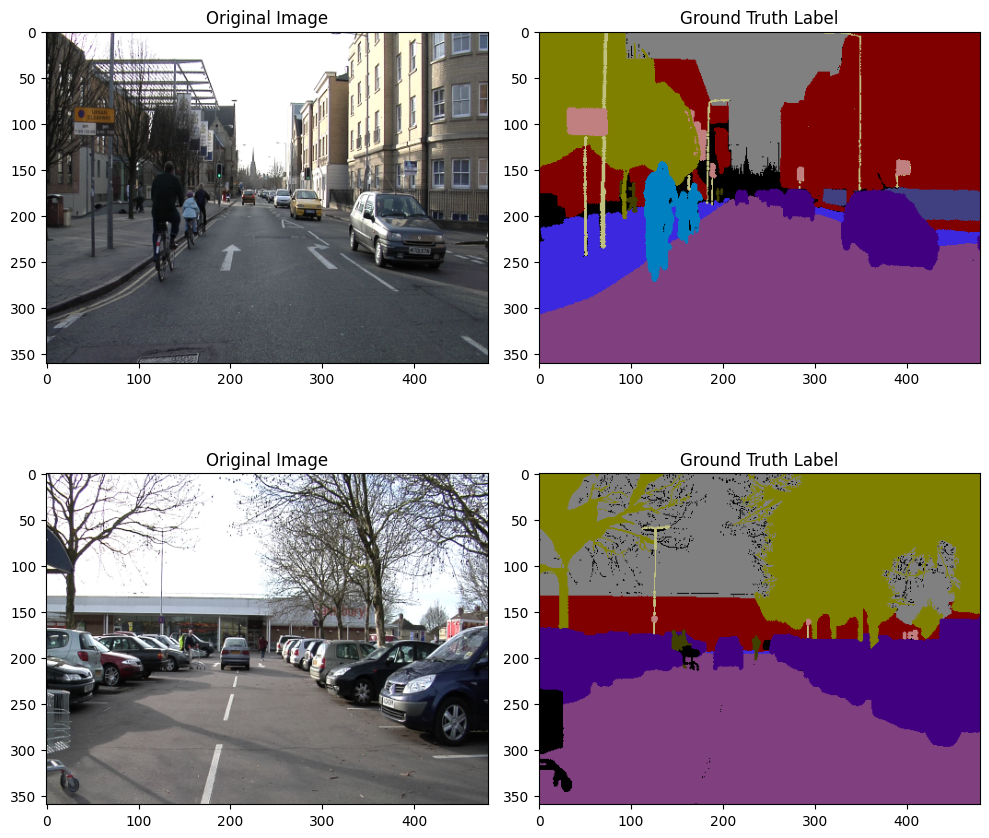

In [ ]:
plot_dataset_images("train", 2)

#### Convert (720, 960, 3) RGB Label Images to Grayscale Class Label Images

The labels for the (720, 960, 3) dataset are in RGB format. In order to use them as labels for the model, the images need to be converted to (720, 960) grayscale class label images in line with the (360, 480) labels.

In [ ]:
if input_size == (720,960,3):

  # Checks if the path has been created. If it has, it won't run the code below.

  if os.path.exists(train_map_path):
    pass

  else:

    file_names = os.listdir(train_mask_path)
    os.makedirs(train_map_path, exist_ok=True)
    for file_name in file_names:
      try:
        file_path = os.path.join(train_mask_path, file_name)
        img = Image.open(file_path, 'r')
        width, height = img.size
        pixel_values = tuple(img.getdata())
        category_map = np.array([rgb_to_idx[rgb] for rgb in pixel_values], dtype=np.uint8).reshape(height, width)
        category_image = Image.fromarray(category_map)
        category_image.save(f'{train_map_path}/{os.path.splitext(file_name)[0]}.png')
      except:
        print(f'Issue with file {file_path}')

    file_names = os.listdir(val_mask_path)
    os.makedirs(val_map_path, exist_ok=True)
    for file_name in file_names:
      try:
        file_path = os.path.join(val_mask_path, file_name)
        img = Image.open(file_path, 'r')
        width, height = img.size
        pixel_values = tuple(img.getdata())
        category_map = np.array([rgb_to_idx[rgb] for rgb in pixel_values], dtype=np.uint8).reshape(height, width)
        category_image = Image.fromarray(category_map)
        category_image.save(f'{val_map_path}/{os.path.splitext(file_name)[0]}.png')
      except:
        print(f'Issue with file {file_path}')

    file_names = os.listdir(test_mask_path)
    os.makedirs(test_map_path, exist_ok=True)
    for file_name in file_names:
      try:
        file_path = os.path.join(test_mask_path, file_name)
        img = Image.open(file_path, 'r')
        width, height = img.size
        pixel_values = tuple(img.getdata())
        category_map = np.array([rgb_to_idx[rgb] for rgb in pixel_values], dtype=np.uint8).reshape(height, width)
        category_image = Image.fromarray(category_map)
        category_image.save(f'{test_map_path}/{os.path.splitext(file_name)[0]}.png')
      except:
        print(f'Issue with file {file_path}')


#### Class Imbalance Analysis

Unlike image classification where each image is assigned a single label, in semantic segmentation each pixel in the input image is assigned to a class. Given this difference, the method for calculating class imbalance must be done at the pixel level, not the image level.

The bar plot below shows the number of pixels classified as each of the 12 classes and shows a great deal of class imbalance. The class mix makes sense for a dataset consisting of images taken from a car driving through a city. For example, "road", "building" and "sky" are the top three classes by total pixels. Other relatively large and common objects that make up the 2nd tier in terms of total pixels are "tree, "car", and "sidewalk". Small objects like "sign_symbol", "pole", "pedestrian", and "bicyclist" make up a small number of total pixels. "Fence" is likely not generally a small object but there are likely few fences in the area where the images were taken.

In [ ]:
file_names = [file_name for file_name in os.listdir(train_map_path) if file_name.endswith('png')]
pixel_counts = np.zeros((len(file_names), num_classes), dtype=int)

for i, file_name in enumerate(file_names):
  file_path = os.path.join(train_map_path, file_name)
  img = Image.open(file_path, 'r')
  img_array = np.array(img)
  flat_array = img_array.flatten()
  counts = np.bincount(flat_array)
  if counts.size < num_classes:
    counts = np.pad(counts, (0, num_classes + 1 - counts.size))
  pixel_counts[i] = counts

In [ ]:
pixel_count_df = pd.DataFrame(pixel_counts)

In [ ]:
pixel_count_names_df = pixel_count_df.copy()

In [ ]:
pixel_count_names_df.rename(columns=idx_to_name, inplace=True)

In [ ]:
class_pixels = pixel_count_df.sum()

In [ ]:
names_pixels = pixel_count_names_df.sum()

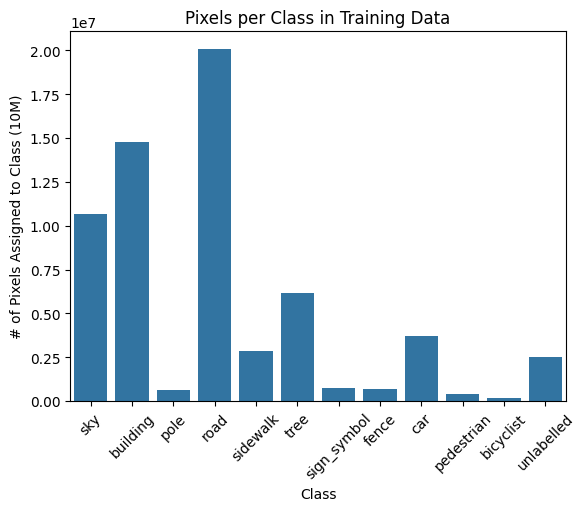

In [ ]:
sns.barplot(names_pixels)
plt.xticks(rotation=45)
plt.xlabel('Class')
plt.ylabel('# of Pixels Assigned to Class (10M)')
plt.title('Pixels per Class in Training Data')
plt.show();

There are two primary ways to deal with class imbalance for semantic segmentation. The first is to use focal loss as the loss function in training. This loss is a scaled version of cross-entropy that is designed with hyperparameters Gamma and Alpha that work together to scale up the magnitude of loss attributable to difficult classify classes (e.g. low frequency classes). In this way they focus training on difficult to classify classes. Unfortunately, TensorFlow (which I used for the project) doesn't have a built in version of focal loss that works with sparse labels. Given the types of labels I have, working with sparse labels is much more straightforward.

The second option for class imbalance is to implement class balancing by using class weights, which increase the weight of the loss attributable to classes with low frequency. The authors of the SegNet paper used median frequency class balancing on the CamVid dataset, and so I implemented the same strategy.

Median frequency balancing scales the loss attributable to each class by multiplying it by the ratio of median class frequency to the specific class frequency. In this way classes with lower than the median frequency have their loss scaled up, and classes with higher frequency have their loss scaled down. Class frequency is calculated as the total number of pixels belonging to the class in the training dataset divided by the total number of pixels of all images in the training dataset that have at least 1 pixel of that class.


#### Median Frequency Class Balancing Weights Calculation

This code creates a list of class weights based on median frequency class balancing to address class imbalance in the dataset.

In [ ]:
image_wclass_pixels = (pixel_count_df > 0).sum()*(360*480)
class_frequency = class_pixels / image_wclass_pixels
median_frequency = np.median(class_frequency)
class_weights = median_frequency / class_frequency
class_weights_list = list(class_weights)

#### tf.data.Dataset Creation

The code below creates a tf.data.Dataset for efficient model training.

In [ ]:
def parse_image(img_path, map_path):
    # Opens image from path, casts it to TF format and applies VGG16 preprocessing to it
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)

    # Opens label (which is an image) from path, casts it to TF format
    label = tf.io.read_file(map_path)
    label = tf.image.decode_png(label, channels=1)
    label = tf.cast(label, tf.float32)

    return img, label


def load_dataset(img_dir, map_dir):
    # Gets list of paths for all images, labels
    img_paths = [os.path.join(img_dir, file_name) for file_name in sorted(os.listdir(img_dir)) if file_name.endswith('png')]
    map_paths = [os.path.join(map_dir, file_name) for file_name in sorted(os.listdir(map_dir)) if file_name.endswith('png')]

    # Creates tf.data.Dataset from list of paths
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, map_paths))
    # Maps parse_image code to each element of the dataset
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)

    return dataset


In [ ]:
# Source: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# code to use sample_weights to implement median frequency class balancing
# to address class imbalance
def add_sample_weights(image, label):
  class_weights = tf.constant(class_weights_list)

  # Create an image of `sample_weights` by using the label at each pixel as an
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [ ]:
# Loads dataset, applies standard tf.data.Dataset transformations and dataset tools
train_dataset = load_dataset(train_image_path, train_map_path)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(len(train_dataset))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
# Applies add_sample_weights if class_balancing is set to True in Global Variables section

if class_balancing == True:
  train_dataset = train_dataset.map(add_sample_weights)

# Loads dataset, applies standard tf.data.Dataset transformations and dataset tools
val_dataset = load_dataset(val_image_path, val_map_path)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.shuffle(len(val_dataset))
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Loads dataset, applies standard tf.data.Dataset transformations and dataset tools
test_dataset = load_dataset(test_image_path, test_map_path)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### 7. U-Net Model Creation

For my semantic segmentation model I opted to use a U-Net model. The U-Net model features an encoder/decoder architecture and is similar to an auto-encoder, except that it also has skip connections, with each encoder layer passing its output prior to max pooling to the decoder layer that has the same dimensions. In this way the model has more capacity than an autoencoder which permits it to perform semantic segmentation. For my model training I use a pre-trained VGG16 as the encoder with no top. The whole model including the matching decoder layers and skip connections is built using the Keras functional API. It is possible to unfreeze all or part of the VGG16 model, but aside from some initial experiments I opted to keep the whole encoder frozen during training so that I only had to train the decoder.

This diagram from the original "U-Net: Convolutional Networks for Biomedical
Image Segmentation" paper (https://arxiv.org/pdf/1505.04597) illustrates the U-Net Model's overall architecture.


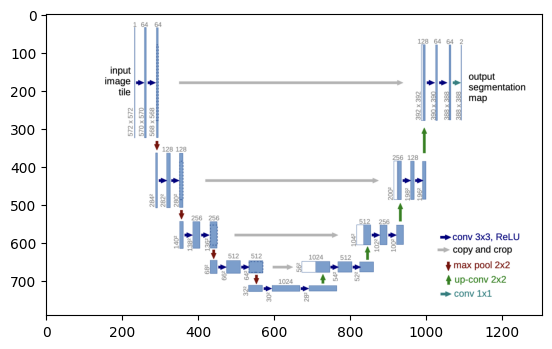

In [ ]:
plt.imshow(Image.open('/content/drive/MyDrive/unet_picture.png', 'r'));

#### VGG16 Model Architecture

To build the custom U-Net model, each encoder block has a skip connection to its corresponding decoder block, where the encoder block's dimensions prior to max pooling matches the decoder blocks input size. Using model.summary() shows each encoder layer in order to determine the skip connections needed for the model.

In [ ]:
# Loads a Keras VGG16 model with the top removed and with pre-trained "imagenet" weights
# input_size is set in the global variables cell above
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=input_size))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 360, 480, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 360, 480, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 360, 480, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 180, 240, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 180, 240, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 180, 240, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 90, 120, 128)      0     

#### Code to Build U-Net Model

In [ ]:
# This function builds a single decoder block. The number of convolutions need
# to match in the corresponding  encoder and decoder layers. The skip_connections are
# passed in to the decoder layer using the function.
def decoder_block(num_convs, input, skip_connections, num_filters):

  x = tf.keras.layers.Conv2DTranspose(num_filters,
                                        (2, 2),
                                        strides = 2,
                                        padding = 'same')(input)
  # Resize is used to ensure that the size of encoder and decoder layers match, regardless of input size.
  x = tf.image.resize(x, size = (skip_connections.shape[1], skip_connections.shape[2]))
  x = tf.keras.layers.Concatenate()([x, skip_connections])

  for i in range(num_convs):
    x = tf.keras.layers.Conv2D(num_filters, 3,  padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)

  return x

In [ ]:
# This function builds out the whole U-Net model using the Keras functional API
def unet_model_builder(num_classes, input_size, encoder_status):

  # pre-trained vgg16 encoder. Whether to freeze weights or not is set in global variables cell.
  vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=input_size))
  if encoder_status == "frozen":
    vgg16.trainable = False


  # outputs of each encoder block used as skip connections for decoder
  skip_1 = vgg16.get_layer('block1_conv2').output # 64 feature maps in output
  skip_2 = vgg16.get_layer('block2_conv2').output # 128 feature maps in output
  skip_3 = vgg16.get_layer('block3_conv3').output # 256 feature maps in output
  skip_4 = vgg16.get_layer('block4_conv3').output # 512 feature maps in output
  skip_5 = vgg16.get_layer('block5_conv3').output # 512 feature maps in output

  # bottleneck (output of vgg16 model)
  vgg16_output = vgg16.get_layer('block5_pool').output

  # decoder_blocks
  d_1 = decoder_block(num_convs=2, input=vgg16_output, skip_connections=skip_5, num_filters=512)
  d_2 = decoder_block(num_convs=2, input=d_1, skip_connections=skip_4, num_filters=512)
  d_3 = decoder_block(num_convs=2, input=d_2, skip_connections=skip_3, num_filters=256)
  d_4 = decoder_block(num_convs=3, input=d_3, skip_connections=skip_2, num_filters=128)
  d_5 = decoder_block(num_convs=3, input=d_4, skip_connections=skip_1, num_filters=64)

  # Output
  outputs = Conv2D(num_classes, 1, padding = 'same', activation = 'softmax')(d_5)

  model = tf.keras.models.Model(inputs = vgg16.inputs,
                                  outputs = outputs,
                                  name = 'U-Net_VGG16')
  return model

In [ ]:
unet_model = unet_model_builder(num_classes=num_classes, input_size=input_size, encoder_status=encoder_status)

#### U-Net Model Summary

In [ ]:
unet_model.summary()

Model: "U-Net_VGG16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 360, 480, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 360, 480, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 360, 480, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 180, 240, 64)         0         ['block1_conv2[0][0]']        
                                                                                        

#### U-Net Model Plot

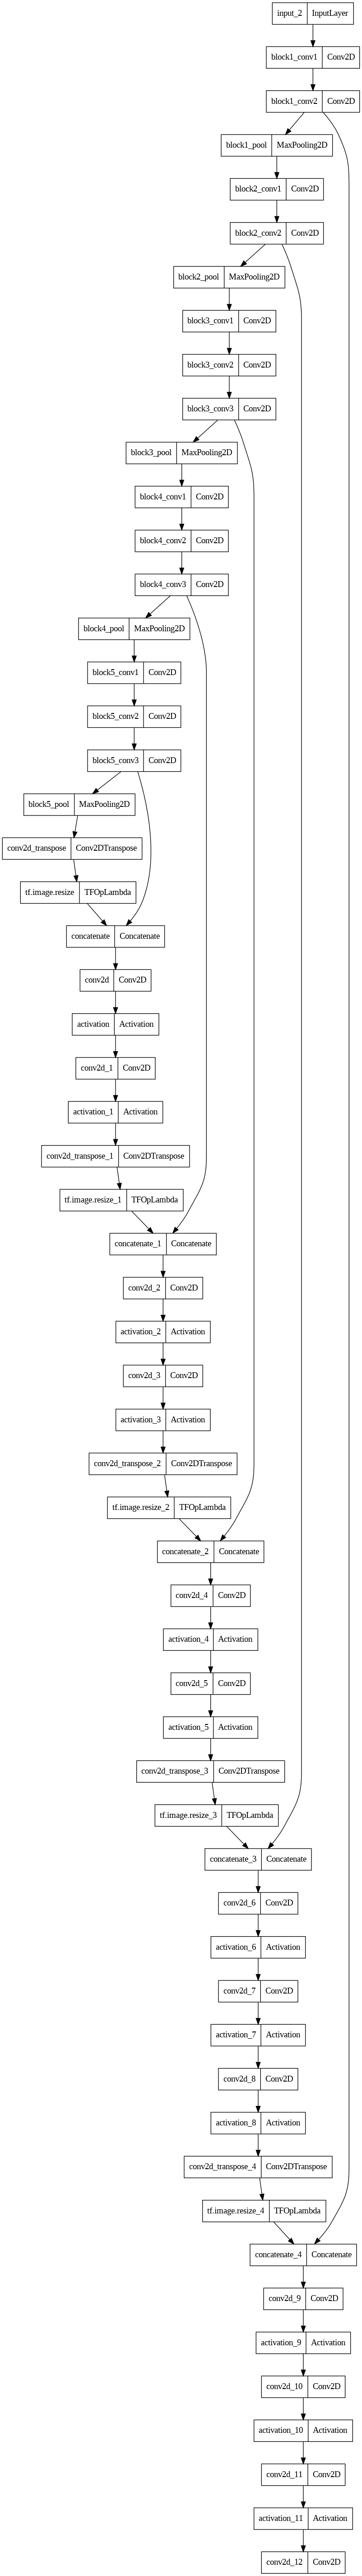

In [ ]:
plot_model(unet_model)

### 9. Training Code

The code below is used to train and save the U-Net model.

#### Callbacks

In [ ]:
# assigns a random id to each training run for history and model checkpoint identification
run_id = random.randint(100000,999999)

In [ ]:
# allows training to stop if learning appears stuck (optional)
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=20,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0)

# used to capture training history
hist = tf.keras.callbacks.History()

# sets checkpoint path depending on which loss is used, gamma value (focal loss hyperparameter),
# whether the encoder is frozen, the random run_id, and the number of epochs
if loss_function == "focal_loss":
  checkpoint_path = f'/content/drive/MyDrive/cv_final_project/unet_focal_gamma_{gamma}_{encoder_status}_size_{input_size}_{run_id}_epochs_{epochs}_checkpoints'
else:
  checkpoint_path = f'/content/drive/MyDrive/cv_final_project/unet_cross_balanced_{class_balancing}_{encoder_status}_size_{input_size}_{run_id}_epochs_{epochs}_checkpoints'


# code to save a keras version of model
keras_mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'{checkpoint_path}/keras/best_model.keras',
    monitor='val_updated_mean_io_u',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    save_freq='epoch',
    initial_value_threshold=None)

# code to save a tf version of model
tf_mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'{checkpoint_path}/tf',
    monitor='val_updated_mean_io_u',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    save_freq='epoch',
    initial_value_threshold=None)

#code to save an h5 version of model
h5_mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'{checkpoint_path}/h5/best_model.h5',
    monitor='val_updated_mean_io_u',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    save_freq='epoch',
    initial_value_threshold=None)

# full callbacks list, edit as desired
callbacks = [hist, keras_mc, h5_mc, tf_mc]

In [ ]:
# Keras' built-in MeanIOU was throwing a dimension mismatch error, I found
# this workaround on stack overflow. Creates a custom version of MeanIoU.
# https://stackoverflow.com/questions/61824470/
# dimensions-mismatch-error-when-using-tf-metrics-meaniou-with-sparsecategorical

class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None,
               ignore_class=None,
               sparse_y_true=True,
               sparse_y_pred=True,
               axis=-1):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)


  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

# iou is passed to model.compile as part of a list for the metrics parameter
iou = UpdatedMeanIoU(num_classes=num_classes)

#### Learning Rate

In [ ]:
# optional exponential decay lerning rate
initial_learning_rate = 0.001
exponential_lr = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=46,
    decay_rate=0.99,
    staircase=False)


#### Loss function

In [ ]:
# determines which loss to use, based on code in global variables cell
if loss_function == "focal_loss":
  loss = focal_loss.SparseCategoricalFocalLoss(gamma=gamma)
else:
  loss = keras.losses.SparseCategoricalCrossentropy()

#### Compile the Model



In [ ]:
# uncomment to compile model
# pass learning rate to optimizer, set loss and metrics in cells above
#unet_model.compile(optimizer=Adam(learning_rate=exponential_lr),loss=loss, metrics=[iou])

#### Train the model

In [ ]:
# uncomment to train model
# results are passed to history variable, set callbacks in callbacks cell above
#history = unet_model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=callbacks)

#### Save History

In [ ]:
# converts history.hitory dictionary to JSON
# uncomment to save history

#history_json = json.dumps(history.history)

# saves history, with path using same identifying into as checkpoint
#if loss_function == "focal_loss":
  #history_path = f'/content/drive/MyDrive/cv_final_project/training_history/history_focal_gamma_{gamma}_{encoder_status}_size_{input_size}_{run_id}_epochs_{epochs}.json'
#else:
  #history_path = f'/content/drive/MyDrive/cv_final_project/training_history/history_cross_balanced_{class_balancing}_{encoder_status}_size_{input_size}_{run_id}_epochs_{epochs}.json'

#with open(history_path, 'w') as f:
    #f.write(history_json)

### 10. Training Results

After many experiments with hyperparameter tuning, I settled on using the Adam optimizer with the learning rate set to 0.001 with exponential decay with an exponential decay rate of .99, decay_step set to 46 and no staircase. With these settings, the model performs well both when using class balancing and when not, though with a slight edge for the version that corrects for class imbalance. Additional hyper-parameter tuning may help improve results for both versions, as could additional efforts to avoid overfitting.



In [ ]:
file_path = '/content/drive/MyDrive/cv_final_project/training_history/history_cross_balanced_False_frozen_size_(360, 480, 3)_963750_epochs_120.json'
with open(file_path, 'r') as file:
    cross_history = json.load(file)


file_path = '/content/drive/MyDrive/cv_final_project/training_history/history_cross_balanced_True_frozen_size_(360, 480, 3)_867477_epochs_120.json'
with open(file_path, 'r') as file:
    balanced_cross_history = json.load(file)


In [ ]:
def plot_history(history_data):
  fig, ax = plt.subplots(2,2, figsize=(10,10))
  ax = ax.flatten()
  sns.lineplot(history_data['loss'], ax=ax[0])
  ax[0].set_title('Training Loss')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')

  sns.lineplot(history_data['updated_mean_io_u'],  ax=ax[1])
  ax[1].set_title('Training Mean IoU')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Mean IoU')

  sns.lineplot(history_data['val_loss'],  ax=ax[2])
  ax[2].set_title('Validation_Loss')
  ax[2].set_xlabel('Epochs')
  ax[2].set_ylabel('Loss')

  sns.lineplot(history_data['val_updated_mean_io_u'],  ax=ax[3])
  ax[3].set_title('Validation Mean IoU')
  ax[3].set_xlabel('Epochs')
  ax[3].set_ylabel('Mean IoU')
  plt.tight_layout()
  plt.show();

#### Training History Sparse Categorical Cross-Entropy

The training without class balancing performed well on validation Mean IoU, though validation loss increasing while training loss continues to decline points to some overfitting.

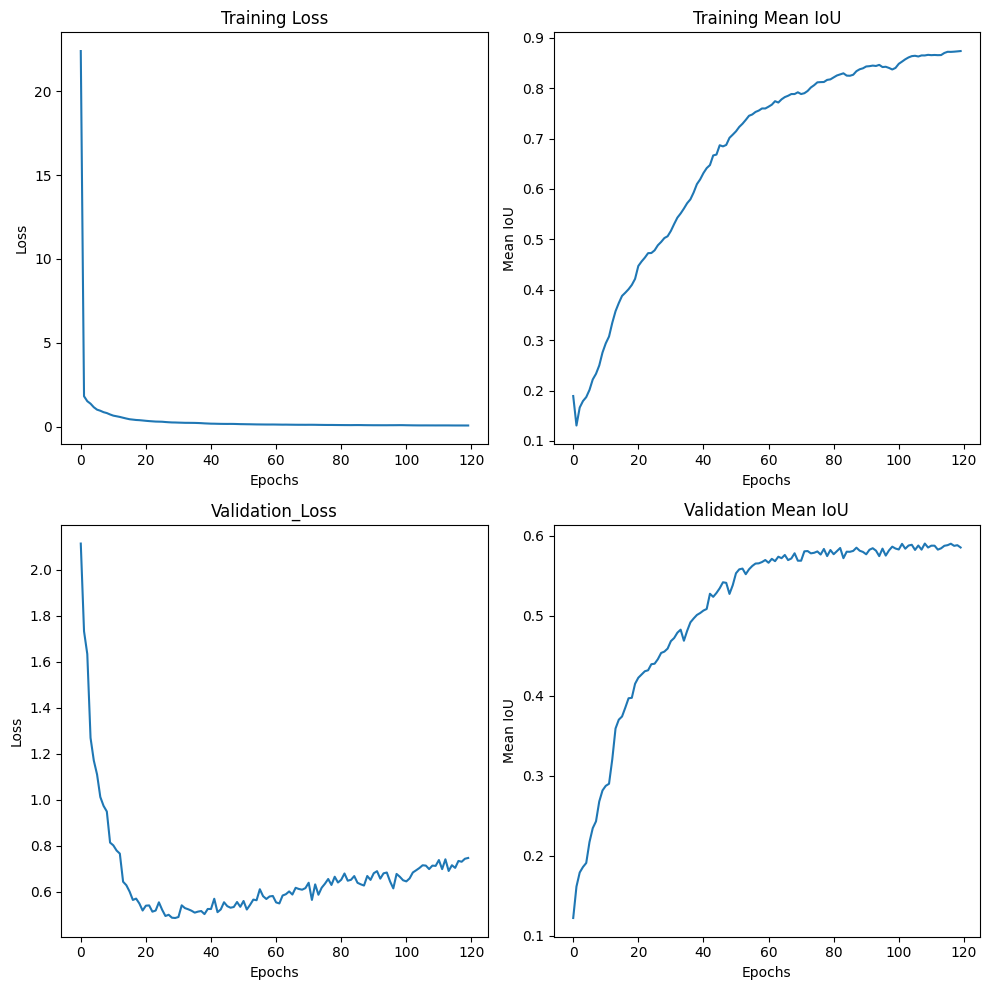

In [ ]:
plot_history(cross_history)

#### Training History Sparse Categorcial Cross-Entropy with Median Frequency Class Balancing

Training with class balancing has went slightly better than without class balancing, as the increase in validation loss towards the end is less pronounced (implying less overfitting) and the validation Mean IoU scores attained are slightly higher.

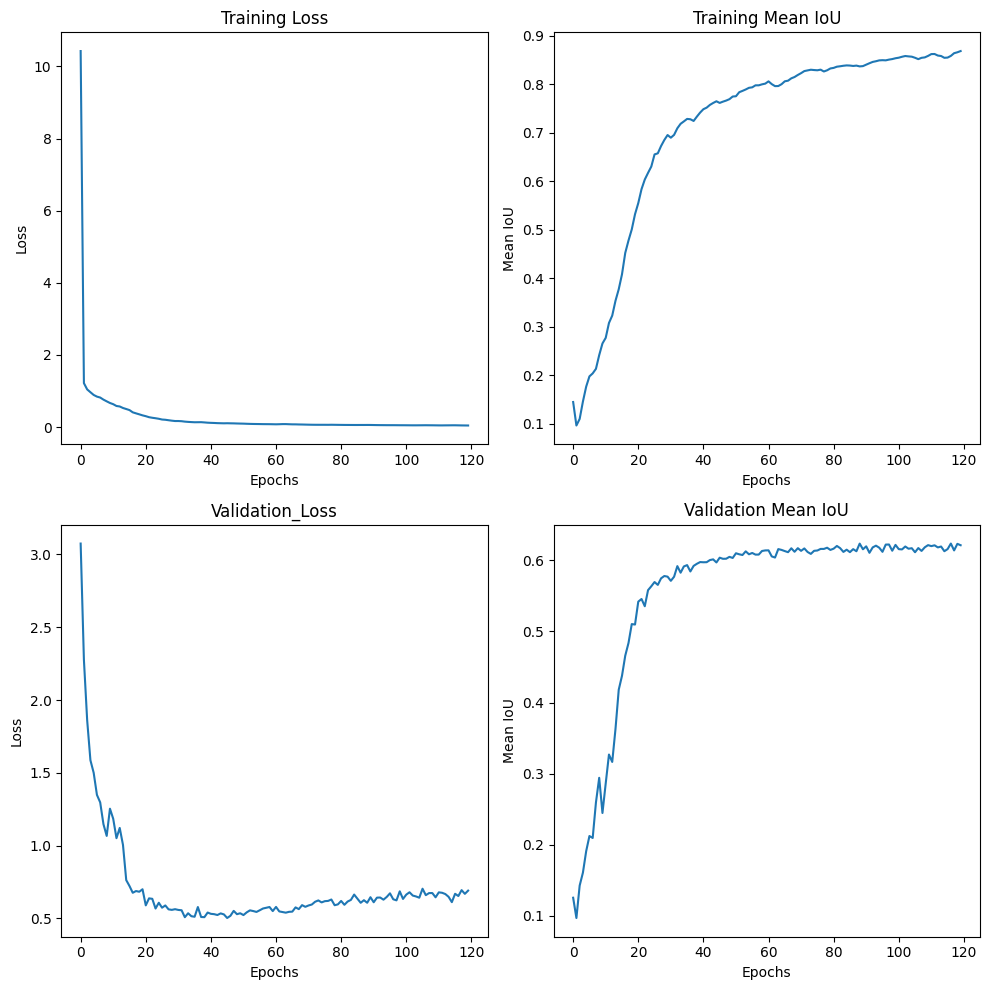

In [ ]:
plot_history(balanced_cross_history)

#### Best Model Metrics and Predictions

Based on the chosen hyperparameters, the model trained with class balancing was the top performing model. Below you can see the train and test Mean IoU of the best saved model and examples of predictions using the model on train and test images.

In [ ]:
model_path = '/content/drive/MyDrive/cv_final_project/unet_cross_balanced_True_frozen_size_(360, 480, 3)_867477_epochs_120_checkpoints/h5/best_model.h5'
unet_model = load_model(model_path, custom_objects={'UpdatedMeanIoU': UpdatedMeanIoU})

In [ ]:
train_results = unet_model.evaluate(train_dataset)

23/23 [==============================] - 118s 2s/step - loss: 0.0467 - updated_mean_io_u: 0.8658


#### Train Mean IoU

In [ ]:
print(f'Train Mean IoU: {train_results[1]:.3f}')

Train Mean IoU: 0.866


#### Test Mean IoU

In [ ]:
test_results = unet_model.evaluate(test_dataset)

15/15 [==============================] - 69s 5s/step - loss: 1.1239 - updated_mean_io_u: 0.5389


In [ ]:
print(f'Test Mean IoU: {test_results[1]:.3f}')

Test Mean IoU: 0.539


In [ ]:
def predict_img(img, model):
  img_array = np.array(img)
  img_array = np.expand_dims(img_array, axis=0)
  processed_img = preprocess_input(img_array)
  pred = model.predict(processed_img)
  pred = np.argmax(pred, axis=3)
  pred = pred.squeeze(axis=0)
  return pred

In [ ]:
def plot_predicted_images(imgs_maps):
  fig, ax = plt.subplots(len(imgs_maps), 3, figsize=(10,10))
  for i, img_map in  enumerate(imgs_maps):
    img = Image.open(img_map[0], 'r')
    map = Image.open(img_map[1], 'r')
    map_array = np.array(map)
    rgb_map = classes_to_rgb(map_array)
    ax[i][0].imshow(img)
    ax[i][0].set_title('Original Image')
    ax[i][1].imshow(rgb_map)
    ax[i][1].set_title('Ground Truth Label')
    pred = predict_img(img, unet_model)
    rgb_pred = classes_to_rgb(pred)
    ax[i][2].imshow(rgb_pred)
    ax[i][2].set_title('Predicted Label')
    plt.tight_layout();

### Train Image Predictions

In [ ]:
imgs_maps = get_imgs_maps("train", 4)

1/1 [==============================] - 0s 29ms/step


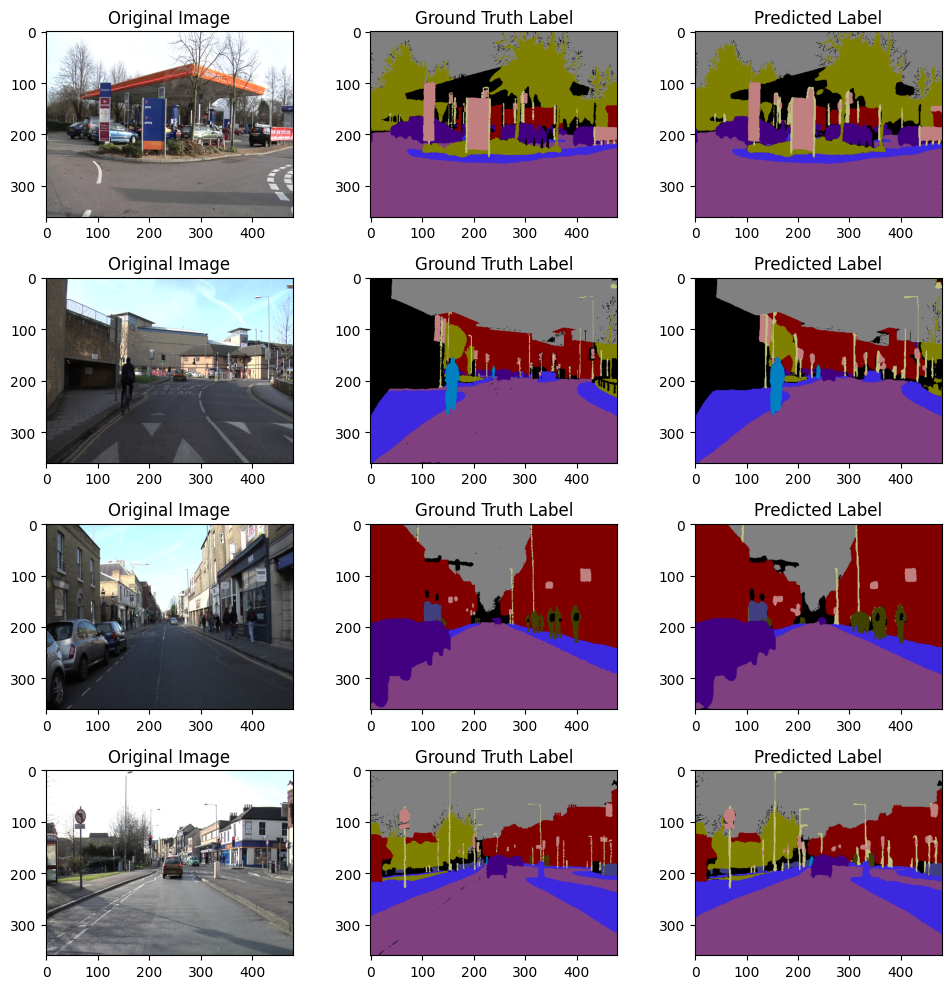

In [ ]:
plot_predicted_images(imgs_maps)

### Test Image Predictions

In [ ]:
imgs_maps = get_imgs_maps("test", 4)

1/1 [==============================] - 0s 20ms/step


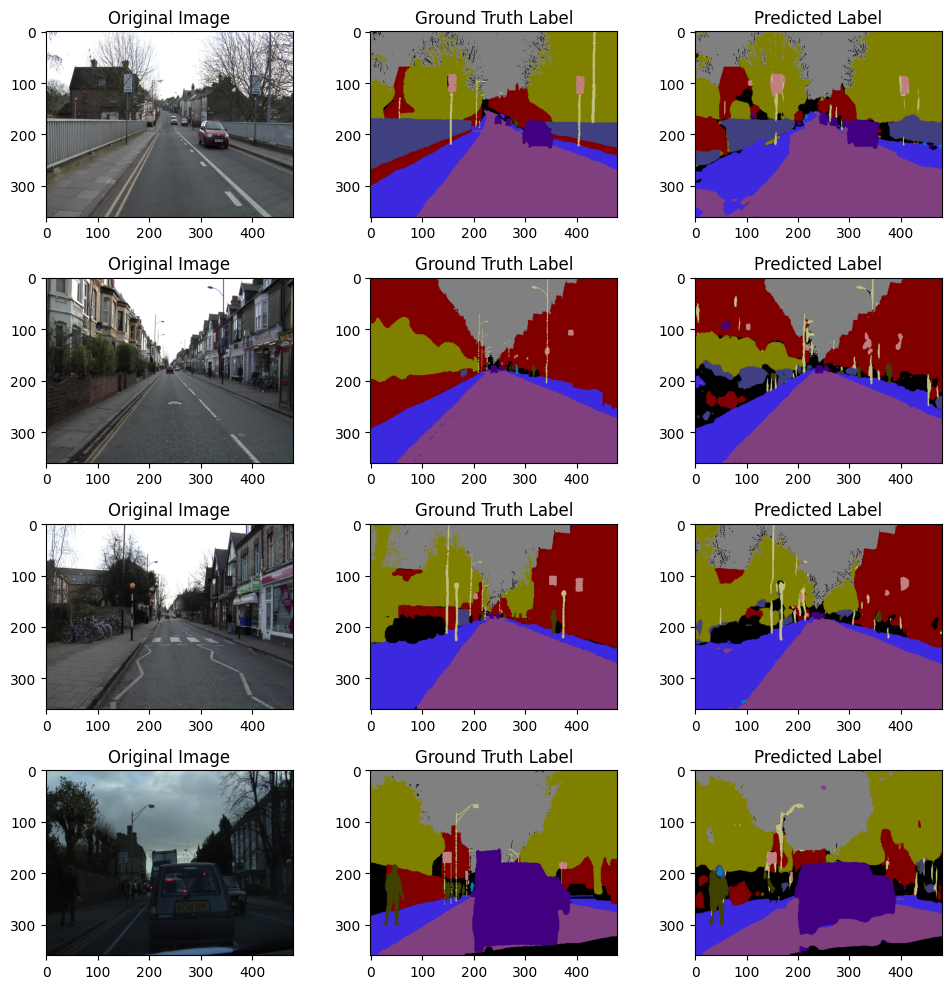

In [ ]:
plot_predicted_images(imgs_maps)